In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Buat direktori untuk menyimpan gambar hasil praproses AHE
if not os.path.exists('preprocessed_images_ahe'):
    os.mkdir('preprocessed_images_ahe')

image_path = "C:/Users/TUF A15/Jupyter Notebook/Pengolahan Citra Digital - Semester 7/paddy-leaf-disease-UCI/train"   

# Definisikan fungsi untuk praproses gambar dengan AHE
def preprocess_image_with_ahe(image_path, output_path):
    # Baca gambar dari path
    image = cv2.imread(image_path)
    
    # Split gambar menjadi saluran warna RGB
    b, g, r = cv2.split(image)
    
    # Terapkan AHE pada setiap saluran
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    ahe_b = clahe.apply(b)
    ahe_g = clahe.apply(g)
    ahe_r = clahe.apply(r)
    
    # Gabungkan kembali saluran warna
    ahe_image = cv2.merge((ahe_b, ahe_g, ahe_r))
    
    # Simpan gambar hasil praproses dengan AHE
    cv2.imwrite(output_path, ahe_image)

# Variabel untuk menyimpan direktori kelas dan output
classes = ['BacterialLeafBlight', 'BrownSpot', 'LeafSmut']

for class_name in classes:
    class_directory = os.path.join(image_path, class_name)
    output_directory = os.path.join('preprocessed_images_ahe', class_name)
    
    if not os.path.exists(output_directory):
        os.mkdir(output_directory)
    
    # Loop through all items in the class directory
    for item in os.listdir(class_directory):
        item_path = os.path.join(class_directory, item)
        
        # Check if it's a directory
        if os.path.isdir(item_path):
            # Ignore files, only process subdirectories
            subdirectory_files = [f for f in os.listdir(item_path) if f.endswith('.jpg')]
            for filename in subdirectory_files:
                image_path = os.path.join(item_path, filename)
                output_path = os.path.join(output_directory, filename)
                print(f"Processing item: {image_path}")
                preprocess_image_with_ahe(image_path, output_path)

print("Pemrosesan gambar dengan AHE selesai pada seluruh dataset.")

Pemrosesan gambar dengan AHE selesai pada seluruh dataset.


In [3]:
if not os.path.exists('segmented_images'):
    os.mkdir('segmented_images')

# Definisikan fungsi untuk segmentasi Otsu thresholding
def segment_image_with_otsu(image_path, output_path):
    # Baca gambar dari path
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Terapkan metode Otsu thresholding
    _, segmented_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Simpan gambar hasil segmentasi
    cv2.imwrite(output_path, segmented_image)

# Ubah path ke direktori hasil praproses AHE
preprocessed_directory = 'preprocessed_images_ahe'

# Ubah path ke direktori hasil segmentasi
segmented_directory = 'segmented_images'

# Loop melalui semua gambar dalam direktori hasil praproses AHE
for class_name in os.listdir(preprocessed_directory):
    class_directory = os.path.join(preprocessed_directory, class_name)
    output_directory = os.path.join(segmented_directory, class_name)
    
    if not os.path.exists(output_directory):
        os.mkdir(output_directory)
    
    for filename in os.listdir(class_directory):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_directory, filename)
            output_path = os.path.join(output_directory, filename)
            segment_image_with_otsu(image_path, output_path)

print("Segmentasi dengan metode Otsu thresholding selesai.")

Segmentasi dengan metode Otsu thresholding selesai.


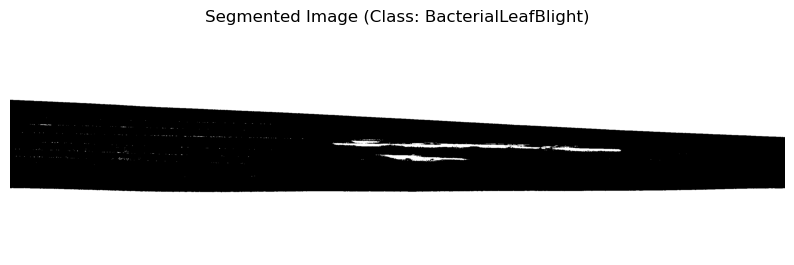

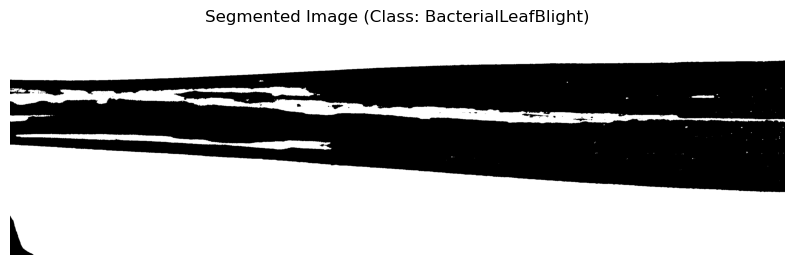

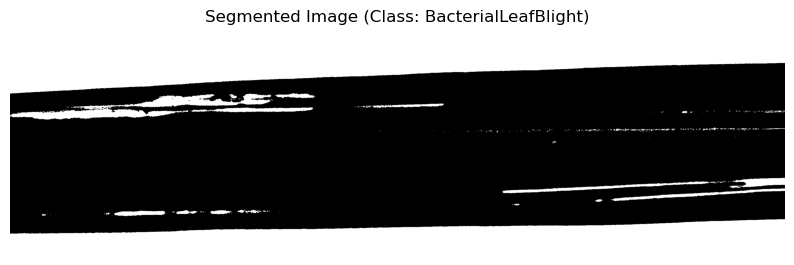

Tampilan beberapa hasil segmentasi Otsu.


In [4]:
# List untuk menyimpan beberapa hasil gambar yang akan ditampilkan
sample_images = []

# Loop melalui semua gambar dalam direktori hasil segmentasi
for class_name in os.listdir(segmented_directory):
    class_directory = os.path.join(segmented_directory, class_name)
    
    for filename in os.listdir(class_directory):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_directory, filename)
            sample_images.append((class_name, image_path))

# Tampilkan beberapa hasil
num_samples = 3  # Tampilkan 3 gambar per kelas
for class_name, image_path in sample_images[:num_samples]:
    segmented_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    plt.figure(figsize=(10, 5))
    plt.title(f'Segmented Image (Class: {class_name})')
    plt.imshow(segmented_image, cmap='gray')
    plt.axis('off')
    
    plt.show()

print("Tampilan beberapa hasil segmentasi Otsu.")

In [5]:
import os
import numpy as np
import cv2
from skimage.feature.texture import graycomatrix, graycoprops
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Inisialisasi daftar semua fitur GLCM yang akan diekstraksi
glcm_features = ['dissimilarity', 'correlation', 'contrast', 'energy', 'homogeneity']

# Inisialisasi list untuk menyimpan fitur-fitur dan label dari dataset pelatihan
training_features = []
training_labels = []

# Inisialisasi list untuk menyimpan fitur-fitur dan label dari dataset pengujian
testing_features = []
testing_labels = []

# Path ke folder dataset pelatihan
training_directory = 'C:/Users/TUF A15/Jupyter Notebook/Pengolahan Citra Digital - Semester 7/paddy-leaf-disease-UCI/train'

# Path ke folder dataset pengujian
testing_directory = 'C:/Users/TUF A15/Jupyter Notebook/Pengolahan Citra Digital - Semester 7/paddy-leaf-disease-UCI/test'

# Loop melalui dataset pelatihan
for class_name in os.listdir(training_directory):
    class_directory = os.path.join(training_directory, class_name)
    
    for filename in os.listdir(class_directory):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_directory, filename)
            
            # Load citra menggunakan OpenCV
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            # Preprocessing AHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image = clahe.apply(image)
            
            # Segmentasi Otsu Thresholding
            _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Ekstraksi semua fitur GLCM dengan rotasi 0, 45, 90, 135, dan 180 derajat
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
            glcm = graycomatrix(image, [1], angles, symmetric=True, normed=True)         
            glcm_props = [graycoprops(glcm, prop) for prop in glcm_features]
            
            # Menambahkan fitur dan label ke dataset pelatihan
            training_features.append(glcm_props)
            training_labels.append(class_name)

# Loop melalui dataset pengujian
for class_name in os.listdir(testing_directory):
    class_directory = os.path.join(testing_directory, class_name)
    
    for filename in os.listdir(class_directory):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_directory, filename)
            
            # Load citra menggunakan OpenCV
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            # Preprocessing AHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image = clahe.apply(image)
            
            # Segmentasi Otsu Thresholding
            _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Ekstraksi semua fitur GLCM dengan rotasi 0, 45, 90, 135, dan 180 derajat
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
            glcm = graycomatrix(image, [1], angles, symmetric=True, normed=True)
            glcm_props = [graycoprops(glcm, prop) for prop in glcm_features]
            
            # Menambahkan fitur dan label ke dataset pengujian
            testing_features.append(glcm_props)
            testing_labels.append(class_name)

# Konversi list fitur dan label ke numpy arrays
X_train = np.array(training_features)
y_train = np.array(training_labels)
X_test = np.array(testing_features)
y_test = np.array(testing_labels)

# Inisialisasi, hyperparameter, dan latih model KNN
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [17, 18, 19, 20, 21], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'leaf_size': [1, 5, 10, 20], 'metric': ['euclidean', 'manhattan', 'minkowski'], 'metric_params': [None]}
knn_grid = GridSearchCV(knn, param_grid=param_grid, cv=5, n_jobs=-1)
knn_grid.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Melakukan prediksi pada dataset pengujian
y_pred = knn_grid.predict(X_test.reshape(X_test.shape[0], -1))

# Mengukur train score dan akurasi model
accuracy = accuracy_score(y_test, y_pred)
train_score = knn_grid.best_score_
print("Best Parameters:", knn_grid.best_params_)
print(f'Train Score: {train_score * 100:.2f}%')
print(f'Accuracy Score: {accuracy * 100:.2f}%')

Best Parameters: {'algorithm': 'ball_tree', 'leaf_size': 1, 'metric': 'manhattan', 'metric_params': None, 'n_neighbors': 18, 'weights': 'distance'}
Train Score: 72.95%
Accuracy Score: 54.55%


### tambah fitur ASM

In [6]:
import os
import numpy as np
import cv2
from skimage.feature.texture import graycomatrix, graycoprops
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Inisialisasi daftar semua fitur GLCM yang akan diekstraksi
glcm_features = ['dissimilarity', 'correlation', 'contrast', 'energy', 'homogeneity', 'ASM']

# Inisialisasi list untuk menyimpan fitur-fitur dan label dari dataset pelatihan
training_features = []
training_labels = []

# Inisialisasi list untuk menyimpan fitur-fitur dan label dari dataset pengujian
testing_features = []
testing_labels = []

# Path ke folder dataset pelatihan
training_directory = 'C:/Users/TUF A15/Jupyter Notebook/Pengolahan Citra Digital - Semester 7/paddy-leaf-disease-UCI/train'

# Path ke folder dataset pengujian
testing_directory = 'C:/Users/TUF A15/Jupyter Notebook/Pengolahan Citra Digital - Semester 7/paddy-leaf-disease-UCI/test'

# Loop melalui dataset pelatihan
for class_name in os.listdir(training_directory):
    class_directory = os.path.join(training_directory, class_name)
    
    for filename in os.listdir(class_directory):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_directory, filename)
            
            # Load citra menggunakan OpenCV
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            # Preprocessing AHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image = clahe.apply(image)
            
            # Segmentasi Otsu Thresholding
            _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Ekstraksi semua fitur GLCM dengan rotasi 0, 45, 90, 135, dan 180 derajat
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
            glcm = graycomatrix(image, [1], angles, symmetric=True, normed=True)         
            glcm_props = [graycoprops(glcm, prop) for prop in glcm_features]
            
            # Menambahkan fitur dan label ke dataset pelatihan
            training_features.append(glcm_props)
            training_labels.append(class_name)

# Loop melalui dataset pengujian
for class_name in os.listdir(testing_directory):
    class_directory = os.path.join(testing_directory, class_name)
    
    for filename in os.listdir(class_directory):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_directory, filename)
            
            # Load citra menggunakan OpenCV
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            # Preprocessing AHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image = clahe.apply(image)
            
            # Segmentasi Otsu Thresholding
            _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Ekstraksi semua fitur GLCM dengan rotasi 0, 45, 90, 135, dan 180 derajat
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
            glcm = graycomatrix(image, [1], angles, symmetric=True, normed=True)
            glcm_props = [graycoprops(glcm, prop) for prop in glcm_features]
                       
            # Menambahkan fitur dan label ke dataset pengujian
            testing_features.append(glcm_props)
            testing_labels.append(class_name)

# Konversi list fitur dan label ke numpy arrays
X_train = np.array(training_features)
y_train = np.array(training_labels)
X_test = np.array(testing_features)
y_test = np.array(testing_labels)

# Inisialisasi, hyperparameter, dan latih model KNN
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [17, 18, 19, 20, 21], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'leaf_size': [1, 5, 10, 20], 'metric': ['euclidean', 'manhattan', 'minkowski'], 'metric_params': [None]}
knn_grid = GridSearchCV(knn, param_grid=param_grid, cv=5, n_jobs=-1)
knn_grid.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Melakukan prediksi pada dataset pengujian
y_pred = knn_grid.predict(X_test.reshape(X_test.shape[0], -1))

# Mengukur train score dan akurasi model
accuracy = accuracy_score(y_test, y_pred)
train_score = knn_grid.best_score_
print("Best Parameters:", knn_grid.best_params_)
print(f'Train Score: {train_score * 100:.2f}%')
print(f'Accuracy Score: {accuracy * 100:.2f}%')

Best Parameters: {'algorithm': 'ball_tree', 'leaf_size': 1, 'metric': 'manhattan', 'metric_params': None, 'n_neighbors': 18, 'weights': 'distance'}
Train Score: 72.95%
Accuracy Score: 55.19%


### tambah valid path

In [8]:
import os
import numpy as np
import cv2
from skimage.feature.texture import graycomatrix, graycoprops
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Inisialisasi daftar semua fitur GLCM yang akan diekstraksi
glcm_features = ['dissimilarity', 'correlation', 'contrast', 'energy', 'homogeneity', 'ASM']

# Inisialisasi list untuk menyimpan fitur-fitur dan label dari dataset pelatihan
training_features = []
training_labels = []

# Inisialisasi list untuk menyimpan fitur-fitur dan label dari dataset pengujian
testing_features = []
testing_labels = []

# Inisialisasi list untuk menyimpan fitur-fitur dan label dari dataset validasi
validation_features = []
validation_labels = []

# Path ke folder dataset pelatihan
training_directory = 'C:/Users/TUF A15/Jupyter Notebook/Pengolahan Citra Digital - Semester 7/paddy-leaf-disease-UCI/train'

# Path ke folder dataset pengujian
testing_directory = 'C:/Users/TUF A15/Jupyter Notebook/Pengolahan Citra Digital - Semester 7/paddy-leaf-disease-UCI/test'

# Path ke folder dataset validasi
validation_directory = 'C:/Users/TUF A15/Jupyter Notebook/Pengolahan Citra Digital - Semester 7/paddy-leaf-disease-UCI/valid'

# Loop melalui dataset pelatihan
for class_name in os.listdir(training_directory):
    class_directory = os.path.join(training_directory, class_name)
    
    for filename in os.listdir(class_directory):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_directory, filename)
            
            # Load citra menggunakan OpenCV
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            # Preprocessing AHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image = clahe.apply(image)
            
            # Segmentasi Otsu Thresholding
            _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Ekstraksi semua fitur GLCM dengan rotasi 0, 45, 90, 135, dan 180 derajat
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
            glcm = graycomatrix(image, [1], angles, symmetric=True, normed=True)         
            glcm_props = [graycoprops(glcm, prop) for prop in glcm_features]
            
            # Menambahkan fitur dan label ke dataset pelatihan
            training_features.append(glcm_props)
            training_labels.append(class_name)

# Loop melalui dataset pengujian
for class_name in os.listdir(testing_directory):
    class_directory = os.path.join(testing_directory, class_name)
    
    for filename in os.listdir(class_directory):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_directory, filename)
            
            # Load citra menggunakan OpenCV
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            # Preprocessing AHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image = clahe.apply(image)
            
            # Segmentasi Otsu Thresholding
            _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Ekstraksi semua fitur GLCM dengan rotasi 0, 45, 90, 135, dan 180 derajat
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
            glcm = graycomatrix(image, [1], angles, symmetric=True, normed=True)
            glcm_props = [graycoprops(glcm, prop) for prop in glcm_features]
                       
            # Menambahkan fitur dan label ke dataset pengujian
            testing_features.append(glcm_props)
            testing_labels.append(class_name)

# Loop melalui dataset validasi
for class_name in os.listdir(validation_directory):
    class_directory = os.path.join(validation_directory, class_name)
    
    for filename in os.listdir(class_directory):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_directory, filename)
            
            # Load citra menggunakan OpenCV
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            # Preprocessing AHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image = clahe.apply(image)
            
            # Segmentasi Otsu Thresholding
            _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Ekstraksi semua fitur GLCM dengan rotasi 0, 45, 90, 135, dan 180 derajat
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
            glcm = graycomatrix(image, [1], angles, symmetric=True, normed=True)
            glcm_props = [graycoprops(glcm, prop) for prop in glcm_features]
                       
            # Menambahkan fitur dan label ke dataset validasi
            validation_features.append(glcm_props)
            validation_labels.append(class_name)            
            
# Konversi list fitur dan label ke numpy arrays
X_train = np.array(training_features)
y_train = np.array(training_labels)
X_test = np.array(testing_features)
y_test = np.array(testing_labels)
X_validation = np.array(validation_features)
y_validation = np.array(validation_labels)

# Inisialisasi, hyperparameter, dan latih model KNN
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [17, 18, 19, 20, 21], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'leaf_size': [1, 5, 10, 20], 'metric': ['euclidean', 'manhattan', 'minkowski'], 'metric_params': [None]}
knn_grid = GridSearchCV(knn, param_grid=param_grid, cv=5, n_jobs=-1)
knn_grid.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Melakukan prediksi pada dataset pengujian
y_pred = knn_grid.predict(X_test.reshape(X_test.shape[0], -1))
# Melakukan prediksi pada dataset validasi
y_val_pred = knn_grid.predict(X_validation.reshape(X_validation.shape[0], -1))

# Mengukur train score dan akurasi model
accuracy = accuracy_score(y_test, y_pred)
train_score = knn_grid.best_score_
print("Best Parameters:", knn_grid.best_params_)
print(f'Train Score: {train_score * 100:.2f}%')
print(f'Accuracy Score: {accuracy * 100:.2f}%')

# Mengukur akurasi model pada dataset validasi
validation_accuracy = accuracy_score(y_validation, y_val_pred)
print(f'Validation Score: {validation_accuracy * 100:.2f}%')

Best Parameters: {'algorithm': 'ball_tree', 'leaf_size': 1, 'metric': 'manhattan', 'metric_params': None, 'n_neighbors': 18, 'weights': 'distance'}
Train Score: 72.95%
Accuracy Score: 55.19%
Validation Accuracy Score: 51.44%


### tambah fitur standard deviation

In [13]:
import os
import numpy as np
import cv2
from skimage.feature.texture import graycomatrix, graycoprops
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Inisialisasi daftar semua fitur GLCM yang akan diekstraksi
glcm_features = ['dissimilarity', 'correlation', 'contrast', 'energy', 'homogeneity', 'ASM', 'standard_deviation']

# Inisialisasi list untuk menyimpan fitur-fitur dan label dari dataset pelatihan
training_features = []
training_labels = []

# Inisialisasi list untuk menyimpan fitur-fitur dan label dari dataset pengujian
testing_features = []
testing_labels = []

# Inisialisasi list untuk menyimpan fitur-fitur dan label dari dataset validasi
validation_features = []
validation_labels = []

# Path ke folder dataset pelatihan
training_directory = 'C:/Users/TUF A15/Jupyter Notebook/Pengolahan Citra Digital - Semester 7/paddy-leaf-disease-UCI/train'

# Path ke folder dataset pengujian
testing_directory = 'C:/Users/TUF A15/Jupyter Notebook/Pengolahan Citra Digital - Semester 7/paddy-leaf-disease-UCI/test'

# Path ke folder dataset validasi
validation_directory = 'C:/Users/TUF A15/Jupyter Notebook/Pengolahan Citra Digital - Semester 7/paddy-leaf-disease-UCI/valid'

# Loop melalui dataset pelatihan
for class_name in os.listdir(training_directory):
    class_directory = os.path.join(training_directory, class_name)
    
    for filename in os.listdir(class_directory):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_directory, filename)
            
            # Load citra menggunakan OpenCV
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            # Preprocessing AHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image = clahe.apply(image)
            
            # Segmentasi Otsu Thresholding
            _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Ekstraksi semua fitur GLCM dengan rotasi 0, 45, 90, 135, dan 180 derajat
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
            glcm = graycomatrix(image, [1], angles, symmetric=True, normed=True)         
            #glcm_props = [graycoprops(glcm, prop) for prop in glcm_features]
            
            # Hitung standar deviasi untuk setiap sudut
            glcm_std = np.std(glcm, axis=(0, 1))
            glcm_props = [graycoprops(glcm, prop) for prop in glcm_features[:-1]]  # Exclude 'standard_deviation'
            glcm_props.append(glcm_std)
            
            # Menambahkan fitur dan label ke dataset pelatihan
            training_features.append(glcm_props)
            training_labels.append(class_name)

# Loop melalui dataset pengujian
for class_name in os.listdir(testing_directory):
    class_directory = os.path.join(testing_directory, class_name)
    
    for filename in os.listdir(class_directory):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_directory, filename)
            
            # Load citra menggunakan OpenCV
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            # Preprocessing AHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image = clahe.apply(image)
            
            # Segmentasi Otsu Thresholding
            _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Ekstraksi semua fitur GLCM dengan rotasi 0, 45, 90, 135, dan 180 derajat
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
            glcm = graycomatrix(image, [1], angles, symmetric=True, normed=True)
            #glcm_props = [graycoprops(glcm, prop) for prop in glcm_features]
            
            # Hitung standar deviasi untuk setiap sudut
            glcm_std = np.std(glcm, axis=(0, 1))
            glcm_props = [graycoprops(glcm, prop) for prop in glcm_features[:-1]]  # Exclude 'standard_deviation'
            glcm_props.append(glcm_std)
                       
            # Menambahkan fitur dan label ke dataset pengujian
            testing_features.append(glcm_props)
            testing_labels.append(class_name)

# Loop melalui dataset validasi
for class_name in os.listdir(validation_directory):
    class_directory = os.path.join(validation_directory, class_name)
    
    for filename in os.listdir(class_directory):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_directory, filename)
            
            # Load citra menggunakan OpenCV
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            # Preprocessing AHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image = clahe.apply(image)
            
            # Segmentasi Otsu Thresholding
            _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Ekstraksi semua fitur GLCM dengan rotasi 0, 45, 90, 135, dan 180 derajat
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
            glcm = graycomatrix(image, [1], angles, symmetric=True, normed=True)
            #glcm_props = [graycoprops(glcm, prop) for prop in glcm_features]
            
            # Hitung standar deviasi untuk setiap sudut
            glcm_std = np.std(glcm, axis=(0, 1))
            glcm_props = [graycoprops(glcm, prop) for prop in glcm_features[:-1]]  # Exclude 'standard_deviation'
            glcm_props.append(glcm_std)
                       
            # Menambahkan fitur dan label ke dataset validasi
            validation_features.append(glcm_props)
            validation_labels.append(class_name)            
            
# Konversi list fitur dan label ke numpy arrays
X_train = np.array(training_features)
y_train = np.array(training_labels)
X_test = np.array(testing_features)
y_test = np.array(testing_labels)
X_validation = np.array(validation_features)
y_validation = np.array(validation_labels)

# Inisialisasi, hyperparameter, dan latih model KNN
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [17, 18, 19, 20, 21], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'leaf_size': [1, 5, 10, 20], 'metric': ['euclidean', 'manhattan', 'minkowski'], 'metric_params': [None]}
knn_grid = GridSearchCV(knn, param_grid=param_grid, cv=5, n_jobs=-1)
knn_grid.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Melakukan prediksi pada dataset pengujian
y_pred = knn_grid.predict(X_test.reshape(X_test.shape[0], -1))
# Melakukan prediksi pada dataset validasi
y_val_pred = knn_grid.predict(X_validation.reshape(X_validation.shape[0], -1))

# Mengukur train score dan akurasi model
accuracy = accuracy_score(y_test, y_pred)
train_score = knn_grid.best_score_
print("Best Parameters:", knn_grid.best_params_)
print(f'Train Score: {train_score * 100:.2f}%')
print(f'Accuracy Score: {accuracy * 100:.2f}%')

# Mengukur akurasi model pada dataset validasi
validation_accuracy = accuracy_score(y_validation, y_val_pred)
print(f'Validation Score: {validation_accuracy * 100:.2f}%')

Best Parameters: {'algorithm': 'ball_tree', 'leaf_size': 1, 'metric': 'manhattan', 'metric_params': None, 'n_neighbors': 18, 'weights': 'distance'}
Train Score: 72.95%
Accuracy Score: 55.19%
Validation Score: 51.44%


### tambah fitur variance

In [47]:
import os
import numpy as np
import cv2
from skimage.feature.texture import graycomatrix, graycoprops
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Inisialisasi daftar semua fitur GLCM yang akan diekstraksi
glcm_features = ['dissimilarity', 'correlation', 'contrast', 'energy', 'homogeneity', 'ASM', 'standard_deviation', 'variance']

# Inisialisasi list untuk menyimpan fitur-fitur dan label dari dataset pelatihan
training_features = []
training_labels = []

# Inisialisasi list untuk menyimpan fitur-fitur dan label dari dataset pengujian
testing_features = []
testing_labels = []

# Inisialisasi list untuk menyimpan fitur-fitur dan label dari dataset validasi
validation_features = []
validation_labels = []

# Path ke folder dataset pelatihan
training_directory = 'C:/Users/TUF A15/Jupyter Notebook/Pengolahan Citra Digital - Semester 7/paddy-leaf-disease-UCI/train'

# Path ke folder dataset pengujian
testing_directory = 'C:/Users/TUF A15/Jupyter Notebook/Pengolahan Citra Digital - Semester 7/paddy-leaf-disease-UCI/test'

# Path ke folder dataset validasi
validation_directory = 'C:/Users/TUF A15/Jupyter Notebook/Pengolahan Citra Digital - Semester 7/paddy-leaf-disease-UCI/valid'

# Loop melalui dataset pelatihan
for class_name in os.listdir(training_directory):
    class_directory = os.path.join(training_directory, class_name)
    
    for filename in os.listdir(class_directory):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_directory, filename)
            
            # Load citra menggunakan OpenCV
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            # Preprocessing AHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image = clahe.apply(image)
            
            # Segmentasi Otsu Thresholding
            _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Ekstraksi semua fitur GLCM dengan rotasi 0, 45, 90, 135, dan 180 derajat
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
            glcm = graycomatrix(image, [1], angles, symmetric=True, normed=True)         
            #glcm_props = [graycoprops(glcm, prop) for prop in glcm_features]
            
            # Hitung standar deviasi dan varians untuk setiap sudut
            glcm_std = np.std(glcm, axis=(0, 1))
            glcm_variance = np.var(glcm, axis=(0, 1))
            glcm_props = [graycoprops(glcm, prop) for prop in glcm_features[:-2]]  # Exclude 'standard_deviation' and 'variance'
            glcm_props.append(glcm_std)
            glcm_props.append(glcm_variance)
            
            # Menambahkan fitur dan label ke dataset pelatihan
            training_features.append(glcm_props)
            training_labels.append(class_name)

# Loop melalui dataset pengujian
for class_name in os.listdir(testing_directory):
    class_directory = os.path.join(testing_directory, class_name)
    
    for filename in os.listdir(class_directory):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_directory, filename)
            
            # Load citra menggunakan OpenCV
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            # Preprocessing AHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image = clahe.apply(image)
            
            # Segmentasi Otsu Thresholding
            _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Ekstraksi semua fitur GLCM dengan rotasi 0, 45, 90, 135, dan 180 derajat
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
            glcm = graycomatrix(image, [1], angles, symmetric=True, normed=True)
            #glcm_props = [graycoprops(glcm, prop) for prop in glcm_features]
            
            # Hitung standar deviasi dan varians untuk setiap sudut
            glcm_std = np.std(glcm, axis=(0, 1))
            glcm_variance = np.var(glcm, axis=(0, 1))
            glcm_props = [graycoprops(glcm, prop) for prop in glcm_features[:-2]]  # Exclude 'standard_deviation' and 'variance'
            glcm_props.append(glcm_std)
            glcm_props.append(glcm_variance)
                       
            # Menambahkan fitur dan label ke dataset pengujian
            testing_features.append(glcm_props)
            testing_labels.append(class_name)

# Loop melalui dataset validasi
for class_name in os.listdir(validation_directory):
    class_directory = os.path.join(validation_directory, class_name)
    
    for filename in os.listdir(class_directory):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_directory, filename)
            
            # Load citra menggunakan OpenCV
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            # Preprocessing AHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image = clahe.apply(image)
            
            # Segmentasi Otsu Thresholding
            _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Ekstraksi semua fitur GLCM dengan rotasi 0, 45, 90, 135, dan 180 derajat
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
            glcm = graycomatrix(image, [1], angles, symmetric=True, normed=True)
            #glcm_props = [graycoprops(glcm, prop) for prop in glcm_features]
            
            # Hitung standar deviasi dan varians untuk setiap sudut
            glcm_std = np.std(glcm, axis=(0, 1))
            glcm_variance = np.var(glcm, axis=(0, 1))
            glcm_props = [graycoprops(glcm, prop) for prop in glcm_features[:-2]]  # Exclude 'standard_deviation' and 'variance'
            glcm_props.append(glcm_std)
            glcm_props.append(glcm_variance)
                       
            # Menambahkan fitur dan label ke dataset validasi
            validation_features.append(glcm_props)
            validation_labels.append(class_name)            
            
# Konversi list fitur dan label ke numpy arrays
X_train = np.array(training_features)
y_train = np.array(training_labels)
X_test = np.array(testing_features)
y_test = np.array(testing_labels)
X_validation = np.array(validation_features)
y_validation = np.array(validation_labels)

# Inisialisasi, hyperparameter, dan latih model KNN
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [17, 18, 19, 20, 21], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'leaf_size': [1, 5, 10, 20], 'metric': ['euclidean', 'manhattan', 'minkowski'], 'metric_params': [None]}
knn_grid = GridSearchCV(knn, param_grid=param_grid, cv=5, n_jobs=-1)
knn_grid.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Melakukan prediksi pada dataset pengujian
y_pred = knn_grid.predict(X_test.reshape(X_test.shape[0], -1))
# Melakukan prediksi pada dataset validasi
y_val_pred = knn_grid.predict(X_validation.reshape(X_validation.shape[0], -1))

# Mengukur train score dan akurasi model
accuracy = accuracy_score(y_test, y_pred)
train_score = knn_grid.best_score_
print("Best Parameters:", knn_grid.best_params_)
print(f'Train Score: {train_score * 100:.2f}%')
print(f'Accuracy Score: {accuracy * 100:.2f}%')

# Mengukur akurasi model pada dataset validasi
validation_accuracy = accuracy_score(y_validation, y_val_pred)
print(f'Validation Score: {validation_accuracy * 100:.2f}%')

Best Parameters: {'algorithm': 'ball_tree', 'leaf_size': 1, 'metric': 'manhattan', 'metric_params': None, 'n_neighbors': 18, 'weights': 'distance'}
Train Score: 72.95%
Accuracy Score: 55.19%
Validation Score: 51.44%
